In [1]:
#I added this
#%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)

1.14.0


In [127]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import clothes

%matplotlib inline 

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "/3. New_Deepfashion2_6_categories/Mask_RCNN")
MODEL_DIR = "D:/DCU/Practicum/Datasets/DeepFashion2/Mask RCNN/Clothes/Dataset Splits/3. New_Deepfashion2_6_categories/Mask_RCNN"



config = clothes.CustomConfig()
#CUSTOM_DIR = "D:/DCU/Practicum/Datasets/DeepFashion2/Mask RCNN/Clothes/Dataset Splits/3. New_Deepfashion2_6_categories/dataset"
#CUSTOM_DIR = "D:/DCU/Practicum/Datasets/DeepFashion2/Mask RCNN/Clothes/Dataset Splits/Evaluation/Images"
CUSTOM_DIR = "D:/DCU/Practicum/Datasets/DeepFashion2/Mask RCNN/Clothes/Dataset Splits/Validation Images"

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
    DETECTION_MAX_INSTANCES = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Load validation dataset
dataset = clothes.CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))    




Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [128]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)


# Or, load the last model you trained
#weights_path =model.find_last()
weights_path ="D:/DCU/Practicum/Datasets/DeepFashion2/Mask RCNN/Clothes/Dataset Splits/Evaluation/Mask_RCNN/mask_rcnn_object_0074.h5"

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)    

Loading weights  D:/DCU/Practicum/Datasets/DeepFashion2/Mask RCNN/Clothes/Dataset Splits/Evaluation/Mask_RCNN/mask_rcnn_object_0074.h5


image ID: object.012719.jpg (42) D:/DCU/Practicum/Datasets/DeepFashion2/Mask RCNN/Clothes/Dataset Splits/Validation Images\val\012719.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    3.00000  max:    3.00000  int32
gt_bbox                  shape: (1, 4)                min:  157.00000  max:  894.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  uint8


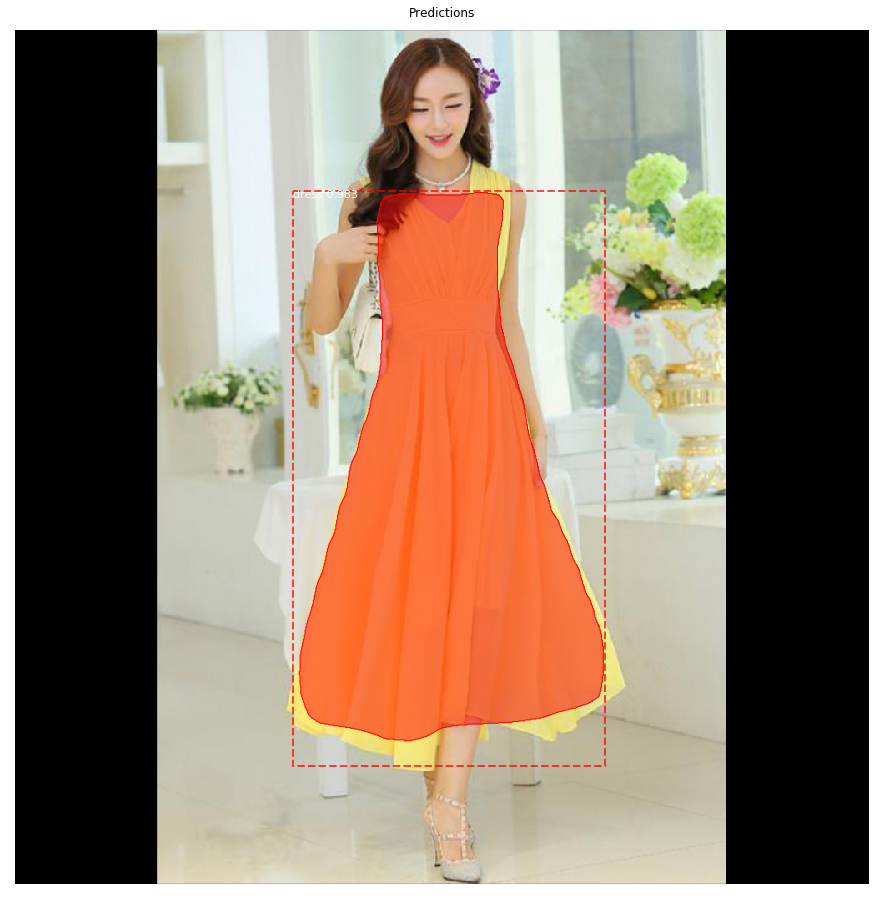

In [129]:
image_id = 42#random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

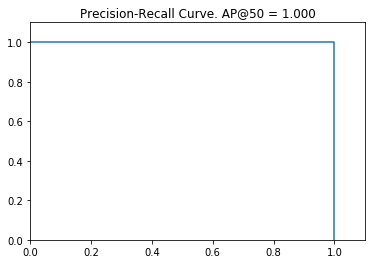

In [130]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

In [131]:

# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10001  float32
res4w_out                shape: (1, 64, 64, 1024)     min:   -0.00000  max:   57.82948  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -7.86309  max:  102.58267  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


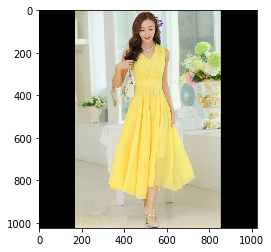

In [132]:
# Input image (normalized) CROPPED
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

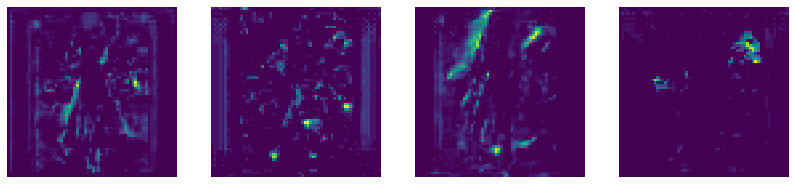

In [133]:
# Backbone feature map CROPPED
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))